In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import wrangle as w
import evaluate as e
import feature_engineering as fe

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [15]:
df = w.clean_zillow()

1590 outliers removed from bedroom.
8559 outliers removed from bathroom.
4412 outliers removed from area.
18673 outliers removed from property_value.
16 outliers removed from year.
21610 outliers removed from tax.

Total of 54860 outliers removed.


In [17]:
df = df.drop(columns="fips")

In [18]:
train, validate, test = w.split_data(df)

In [19]:
train

,bedroom,bathroom,area,property_value,year,tax,orange,ventura
95764,3.0,2.0,1336.0,112579.0,1972.0,1106.58,1,0
26088,2.0,2.0,1882.0,212447.0,1925.0,2679.76,0,0
1873299,2.0,1.0,884.0,241196.0,1927.0,2554.82,0,1
285118,2.0,1.0,833.0,274064.0,1950.0,3490.04,0,0
1900458,4.0,3.0,2840.0,287244.0,1967.0,6415.56,0,0
...,...,...,...,...,...,...,...,...
1842433,2.0,1.0,928.0,438312.0,1941.0,4877.69,0,0
1107106,5.0,3.0,3112.0,391906.0,1965.0,4650.96,1,0
1984259,2.0,1.0,1064.0,305243.0,1941.0,4187.11,0,0
614562,3.0,3.0,2865.0,366909.0,1979.0,4167.64,0,1


In [20]:
def split_into_xy(train, validate, test, target="property_value"):
    x_train = train.drop(target, axis=1)
    y_train = train[target]

    # Split validate data into X and y
    x_validate = validate.drop(target, axis=1)
    y_validate = validate[target]

    # Split test data into X and y
    x_test = test.drop(target, axis=1)
    y_test = test[target]
    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [22]:
x_train, y_train, x_validate, y_validate, x_test, y_test = split_into_xy(train, validate, test, target="property_value")

In [28]:
fe.select_kbest(x_train, y_train, 4)

['bathroom', 'area', 'year', 'tax']

In [29]:
fe.rfe(x_train, y_train, 4)

['bedroom', 'bathroom', 'orange', 'ventura']

In [34]:
def select_kbest(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    mask = kbest.get_support()
    return X.columns[mask]

def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # Dataframe of rankings
    ranks = pd.DataFrame({'rfe_ranking': rfe.ranking_}
                        ,index = X_train.columns)
    
    ranks = ranks.sort_values(by="rfe_ranking", ascending=True)
    
    return ranks

def rfe(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the recursive feature elimination process
        & a df of all rankings
    '''
    #MAKE the thing
    rfe = RFE(LinearRegression(), n_features_to_select=k)
    #FIT the thing
    rfe.fit(X, y)
        
    # use the thing
    features_to_use = X.columns[rfe.support_].tolist()
    
    # we need to send show_feature_rankings a trained/fit RFE object
    all_rankings = show_features_rankings(X, rfe)
    
    return features_to_use, all_rankings

In [36]:
select_kbest(x_train, y_train, 3)

Index(['bathroom', 'area', 'tax'], dtype='object')

In [37]:
rfe(x_train, y_train, 3)

(['bedroom', 'bathroom', 'orange'],
           rfe_ranking
 bedroom             1
 bathroom            1
 orange              1
 ventura             2
 year                3
 tax                 4
 area                5)

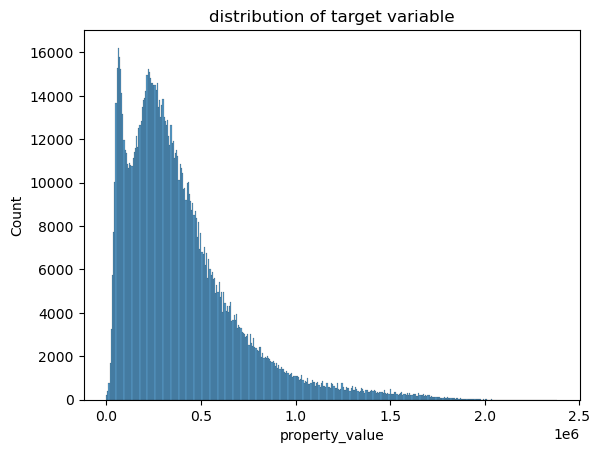

In [38]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

In [39]:
baseline = y_train.mean()
baseline

391230.8025303203

In [40]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [41]:
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([391230.80253032, 391230.80253032, 391230.80253032, 391230.80253032,
       391230.80253032])

In [42]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(296958.64953875216, 0.0)

In [43]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.0


In [126]:
def metric_df(baseline, rmse, r2):
    df = pd.DataFrame(data=[
        {
            'model':'baseline',
            'rmse':rmse,
            'r2':r2
        }

    ])
    return df
   

In [65]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(x_train, y_train)

#use it on train
x_train_rfe = rfe.transform(x_train)

#use it on validate
x_val_rfe = rfe.transform(x_validate)

In [66]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bathroom']


In [67]:
#fit the thing
lr1.fit(x_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(x_train_rfe)
pred_val_lr1 = lr1.predict(x_val_rfe)

In [68]:
#train
metrics_reg(y_train, pred_lr1)

(257785.43762137325, 0.24642791631504113)

In [69]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(257035.71153701728, 0.2470594300116128)

In [70]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.000000
1,ols_1,257035.711537,0.247059


In [71]:
lr1.intercept_

20603.974442771403

In [72]:
lr1.coef_

array([170460.08382959])

In [75]:
print(f'property value = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*bathroom')

property value = 2.06e+04 + 1.7e+05*bathroom


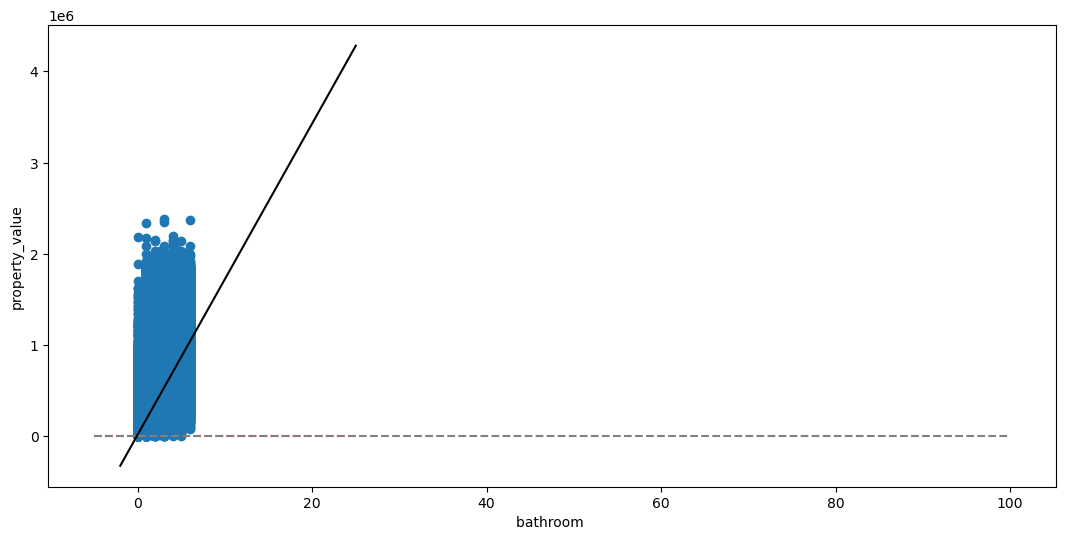

In [82]:
plt.figure(figsize=(13, 6))

plt.scatter(train.bathroom, train.property_value)

#build prediction line from intercept and slope
x_val = np.array([-2, 25]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 25, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 4, ls='--', color='grey')
 
plt.xlabel('bathroom ')
plt.ylabel('property_value')
plt.show()

In [78]:
print(f'For every point increase in bathroom, we predict a {lr1.coef_[0]:.2f} point increase in property value')

For every point increase in bathroom, we predict a 170460.08 point increase in property value


* Multiple Regression -  using OLS

In [83]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(x_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(x_train)

#use it on validate
pred_val_lr2 = lr2.predict(x_validate)

In [84]:
pred_lr2[:10]

array([ 98267.82316908, 222485.57165615, 246245.31647839, 261991.16487872,
       518379.37415298, 426532.57635254, 677030.86616674, 428439.7956891 ,
        37293.85418051, 747356.11298969])

In [85]:
#train 
metrics_reg(y_train, pred_lr2)

(60648.995721053645, 0.9582885517974427)

In [86]:
# validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(60208.3508971109, 0.9586869527995858)

In [87]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.000000
1,ols_1,257035.711537,0.247059
2,ols,60208.350897,0.958687


* LassoLars

In [97]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(x_train, y_train)

#use it
pred_lars = lars.predict(x_train)
pred_val_lars = lars.predict(x_validate)

In [98]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

bedroom     -1810.043414
bathroom        0.000000
area            9.940757
year         -368.810367
tax            83.743013
orange      39298.878064
ventura     42636.672382
dtype: float64

In [99]:
lr2.coef_

array([-5.22658591e+03,  1.81518306e+03,  1.32178490e+01, -5.10934184e+02,
        8.38718153e+01,  4.41851520e+04,  5.02671542e+04])

In [100]:
#train
metrics_reg(y_train, pred_lars)

(60780.37666244092, 0.9581076411363354)

In [101]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(60330.028814603495, 0.958519801066991)

In [102]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.000000
1,ols_1,257035.711537,0.247059
2,ols,60208.350897,0.958687
3,lars,60330.028815,0.958520


* Polynomial Regression

In [105]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)

In [106]:
#make it
pr = LinearRegression()

#fit it
pr.fit(x_train_degree2, y_train)

#use it
pred_pr = pr.predict(x_train_degree2)
pred_val_pr = pr.predict(x_validate_degree2)

In [107]:
#train
metrics_reg(y_train, pred_pr)

(58518.19500806192, 0.9611679887628214)

In [108]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(58215.679364760304, 0.9613763151370003)

In [109]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.000000
1,ols_1,257035.711537,0.247059
2,ols,60208.350897,0.958687
3,lars,60330.028815,0.958520
4,poly_2,58215.679365,0.961376


* Generalized Linear Model (GLM)

In [115]:
#make it
glm = TweedieRegressor(power=0, alpha=0)

#fit it
glm.fit(x_train, y_train)

#use it
pred_glm = glm.predict(x_train)
pred_val_glm = glm.predict(x_validate)

In [116]:
#train
metrics_reg(y_train, pred_glm)

(60866.6973244987, 0.9579885650723585)

In [117]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(60411.49460863617, 0.9584077010415766)

In [118]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,296958.649539,0.000000
1,ols_1,257035.711537,0.247059
2,ols,60208.350897,0.958687
3,lars,60330.028815,0.958520
4,poly_2,58215.679365,0.961376
5,glm,60411.494609,0.958408


In [119]:
#use it
pred_test = pr.predict(x_test_degree2)
pred_test

array([ 250152.94109255,  129121.52028026,  175443.34594628, ...,
       1269978.56119192,  499883.57754053,  417250.92349616])

In [120]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2 

(58369.693878269056, 0.9612075194205725)

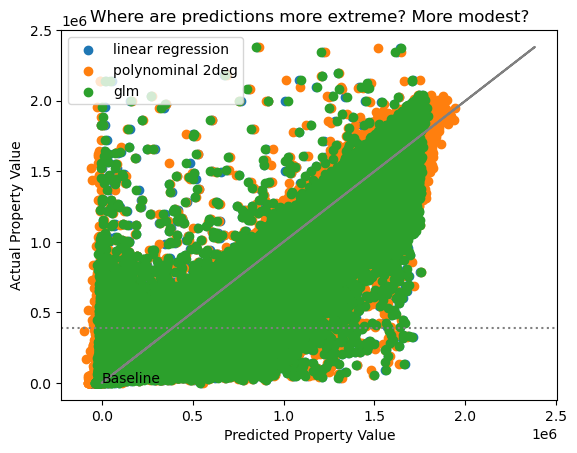

In [121]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Property Value")
plt.xlabel("Predicted Property Value")
plt.legend()

plt.show()

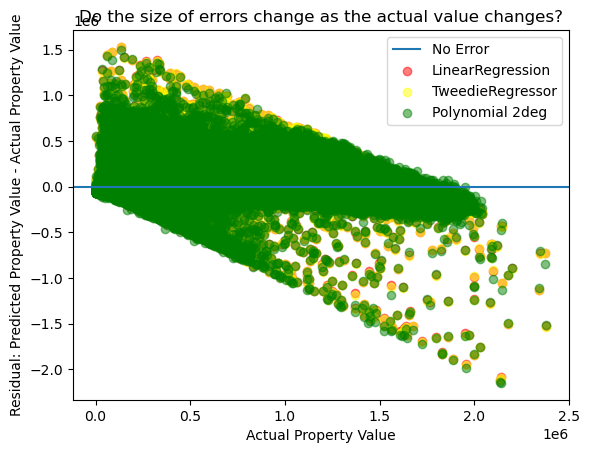

In [123]:
 plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual Property Value")
plt.ylabel("Residual: Predicted Property Value - Actual Property Value")

plt.show()

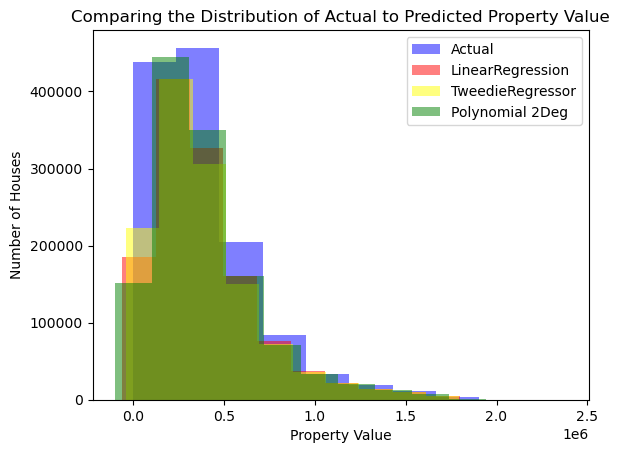

In [124]:
plt.hist(y_train, color='blue', alpha=.5, label="Actual")
plt.hist(pred_lr2, color='red', alpha=.5, label="LinearRegression")
plt.hist(pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")

plt.xlabel("Property Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual to Predicted Property Value")
plt.legend()
plt.show()